In [6]:
# 导入相关依赖
from encoder.utils import convert_audio
import torchaudio
import torch
from decoder.pretrained import WavTokenizer
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# 定义类别
sex_cata = ['male', 'female'] # 性别类别
healthy_cata = ['healthy', 'pathological'] # 健康状况类别
wover_cata = ['a_lhl', 'a_n', 'i_lhl','i_n','u_lhl','u_n'] # 语音特征类别

# 指定数据根目录
input_root = "/mnt/d/Projects/HearToKnowDisease-main/org_data/gender/" # 指定为数据集的路径

In [8]:
# 加载WavTokenizer模型
config_path = "./wavtokenizer_mediumdata_frame75_3s_nq1_code4096_dim512_kmeans200_attn.yaml"
model_path = "./wavtokenizer_medium_speech_320_24k.ckpt"

wavtokenizer = WavTokenizer.from_pretrained0802(config_path, model_path)
wavtokenizer = wavtokenizer.to(device)


# 测试单个文件
wav, sr = torchaudio.load("./1.wav")
wav = convert_audio(wav, sr, 24000, 1) 
bandwidth_id = torch.tensor([0])
wav = wav.to(device)
_,discrete_code = wavtokenizer.encode_infer(wav, bandwidth_id=bandwidth_id)
print("测试单个文件结果:", discrete_code.shape)
discrete_code_np = discrete_code.cpu().numpy()

# 保存测试文件的结果
np.save("./1.npy", discrete_code_np)

测试单个文件结果: torch.Size([1, 1, 10617])


In [9]:
def process_audio_folder(folder_path, output_folder=f"processed_vectors"):
    """处理指定文件夹中的所有音频文件并进行向量化"""
    # 创建输出文件夹
    os.makedirs(output_folder, exist_ok=True)
    
    # 获取所有音频文件
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(('.wav', '.mp3', '.flac'))]
    
    # 准备存储结果的列表
    results = []
    
    # 处理每个音频文件
    for audio_file in tqdm(audio_files, desc=f'处理 {folder_path} 中的文件'):
        file_path = os.path.join(folder_path, audio_file)
        try:
            # 加载音频文件
            wav, sr = torchaudio.load(file_path)
            wav = convert_audio(wav, sr, 24000, 1)
            wav = wav.to(device)
            
            # 编码音频
            bandwidth_id = torch.tensor([0])
            feature, discrete_code = wavtokenizer.encode_infer(wav, bandwidth_id=bandwidth_id)
            discrete_code_np = discrete_code.cpu().numpy()
            feature_np = feature.cpu().numpy()
            
            # 保存向量结果
            output_file = os.path.join(output_folder, os.path.splitext(audio_file)[0] + '.npy')
            np.save(output_file, discrete_code_np)
            
            # 收集结果信息
            results.append({
                'file_name': audio_file,
                'vector': discrete_code_np,
                'feature': feature_np,
                'feature_shape': feature_np.shape,
                'vector_shape': discrete_code_np.shape,
            })
        except Exception as e:
            print(f"处理文件 {audio_file} 时出错: {str(e)}")
    
    return results

In [10]:
# 处理不同类别文件夹并收集结果
all_results = {}

# 创建总结果DataFrame
results_df = pd.DataFrame(columns=['file_name', 'sex', 'health_status', 'voice_feature', 'vector', 'features'])

# 处理每个类别组合
for sex in sex_cata:
    for health in healthy_cata:
        for voice in wover_cata:
            # 构建类别文件夹路径
            if voice:
                category_folder = os.path.join(input_root,f"{sex}/{health}/{voice}")
            else:
                category_folder = os.path.join(input_root, f"{sex}/{health}")
                
            # 检查文件夹是否存在
            if not os.path.exists(category_folder):
                print(f"跳过不存在的文件夹: {category_folder}")
                continue
                
            # 处理当前类别的文件夹
            print(f"处理类别: {sex}, {health}, {voice if voice else 'N/A'}")
            output_folder = f"vectors_{sex}_{health}_{voice if voice else 'none'}"
            
            results = process_audio_folder(category_folder, output_folder)
            
            # 将结果添加到DataFrame
            for result in results:
                result_row = {
                    'file_name': result['file_name'],
                    'sex': sex,
                    'health_status': health,
                    'voice_feature': voice if voice else 'none',
                    'vector': result['vector'],
                    'features': result['feature'],
                }
                results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)
                
            # 存储每个类别的结果
            all_results[f"{sex}_{health}_{voice if voice else 'none'}"] = results

# 保存结果DataFrame到CSV（不包含向量数据）
results_df.drop('vector', axis=1).to_csv('audio_processing_results.csv', index=False)

处理类别: male, healthy, a_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/healthy/a_lhl 中的文件:   0%|          | 0/259 [00:00<?, ?it/s]

处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/healthy/a_lhl 中的文件: 100%|██████████| 259/259 [00:22<00:00, 11.63it/s]


处理类别: male, healthy, a_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/healthy/a_n 中的文件: 100%|██████████| 259/259 [00:33<00:00,  7.75it/s]


处理类别: male, healthy, i_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/healthy/i_lhl 中的文件: 100%|██████████| 259/259 [00:32<00:00,  7.86it/s]


处理类别: male, healthy, i_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/healthy/i_n 中的文件: 100%|██████████| 259/259 [00:30<00:00,  8.55it/s]


处理类别: male, healthy, u_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/healthy/u_lhl 中的文件: 100%|██████████| 259/259 [00:27<00:00,  9.54it/s]


处理类别: male, healthy, u_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/healthy/u_n 中的文件: 100%|██████████| 259/259 [00:31<00:00,  8.31it/s]


处理类别: male, pathological, a_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/pathological/a_lhl 中的文件: 100%|██████████| 626/626 [01:22<00:00,  7.59it/s]


处理类别: male, pathological, a_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/pathological/a_n 中的文件: 100%|██████████| 627/627 [01:30<00:00,  6.90it/s]


处理类别: male, pathological, i_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/pathological/i_lhl 中的文件: 100%|██████████| 625/625 [01:20<00:00,  7.73it/s]


处理类别: male, pathological, i_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/pathological/i_n 中的文件: 100%|██████████| 627/627 [01:17<00:00,  8.13it/s]


处理类别: male, pathological, u_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/pathological/u_lhl 中的文件: 100%|██████████| 626/626 [01:20<00:00,  7.82it/s]


处理类别: male, pathological, u_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/male/pathological/u_n 中的文件: 100%|██████████| 627/627 [01:15<00:00,  8.30it/s]


处理类别: female, healthy, a_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/healthy/a_lhl 中的文件: 100%|██████████| 428/428 [00:51<00:00,  8.37it/s]


处理类别: female, healthy, a_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/healthy/a_n 中的文件: 100%|██████████| 428/428 [00:47<00:00,  8.97it/s]


处理类别: female, healthy, i_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/healthy/i_lhl 中的文件: 100%|██████████| 428/428 [00:48<00:00,  8.77it/s]


处理类别: female, healthy, i_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/healthy/i_n 中的文件: 100%|██████████| 428/428 [00:48<00:00,  8.77it/s]


处理类别: female, healthy, u_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/healthy/u_lhl 中的文件: 100%|██████████| 428/428 [00:48<00:00,  8.78it/s]


处理类别: female, healthy, u_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/healthy/u_n 中的文件: 100%|██████████| 428/428 [00:46<00:00,  9.11it/s]


处理类别: female, pathological, a_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/pathological/a_lhl 中的文件: 100%|██████████| 725/725 [01:28<00:00,  8.20it/s]


处理类别: female, pathological, a_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/pathological/a_n 中的文件: 100%|██████████| 686/686 [01:19<00:00,  8.58it/s]


处理类别: female, pathological, i_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/pathological/i_lhl 中的文件: 100%|██████████| 725/725 [01:28<00:00,  8.23it/s]


处理类别: female, pathological, i_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/pathological/i_n 中的文件: 100%|██████████| 686/686 [01:18<00:00,  8.69it/s]


处理类别: female, pathological, u_lhl


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/pathological/u_lhl 中的文件: 100%|██████████| 725/725 [01:27<00:00,  8.30it/s]


处理类别: female, pathological, u_n


处理 /mnt/d/Projects/HearToKnowDisease-main/org_data/gender/female/pathological/u_n 中的文件: 100%|██████████| 686/686 [01:24<00:00,  8.14it/s]


In [11]:
# 保存包括向量的结果DataFrame
results_df.to_csv('audio_processing_results_with_vectors.csv', index=False)
# 打印完成消息
print("所有文件处理完成，结果已保存到 CSV 文件中。")

所有文件处理完成，结果已保存到 CSV 文件中。


In [12]:
print(results_df.head())  # 打印前几行结果

        file_name   sex health_status voice_feature  \
0   100-a_lhl.wav  male       healthy         a_lhl   
1  1000-a_lhl.wav  male       healthy         a_lhl   
2  1002-a_lhl.wav  male       healthy         a_lhl   
3  1003-a_lhl.wav  male       healthy         a_lhl   
4  1004-a_lhl.wav  male       healthy         a_lhl   

                                              vector  \
0  [[[370, 76, 3674, 3761, 812, 548, 2321, 1687, ...   
1  [[[3426, 2054, 3640, 2091, 2999, 652, 2341, 68...   
2  [[[2502, 526, 2927, 1184, 2601, 2537, 1658, 24...   
3  [[[3224, 1042, 2625, 1998, 3252, 2037, 817, 86...   
4  [[[2967, 903, 2111, 3230, 1465, 231, 3068, 264...   

                                            features  
0  [[[0.27668267, 0.63682157, 0.203737, -0.153015...  
1  [[[-0.045022298, 0.374423, -0.20010626, 0.4012...  
2  [[[0.38399765, -0.16833471, 0.24900268, 0.4311...  
3  [[[0.5963996, -0.119038865, 0.42743698, 0.3971...  
4  [[[-0.0074904305, 0.35260507, 0.14687462, -0.2...  


In [15]:
# 如果内核崩溃了，需要重新导入result_df
import pandas as pd
# 重新加载结果DataFrame
results_df= pd.read_csv("audio_processing_results_with_vectors.csv")

In [13]:
# # 导入相关依赖
# from encoder.utils import convert_audio
# import torchaudio
# import torch
# from decoder.pretrained import WavTokenizer
# import pandas as pd
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm

# device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
def robust_vector_parsing(results_df):
    """
    更健壮的向量解析方法，处理各种CSV中可能出现的向量格式
    """
    normalized_df = results_df.copy()
    
    # 检查是否需要解析向量
    if isinstance(normalized_df['vector'].iloc[0], str):
        print("检测到向量为字符串格式，开始解析...")
        
        # 使用正则表达式提取数字
        import re
        
        def parse_vector_string(vec_str):
            try:
                # 尝试直接用numpy解析
                return np.array(eval(vec_str.replace('\n', '')))
            except:
                try:
                    # 使用正则表达式提取数字
                    numbers = re.findall(r'[-+]?\d*\.\d+|\d+', vec_str)
                    return np.array([int(float(n)) for n in numbers])
                except:
                    # 如果都失败了，返回空数组
                    print(f"无法解析向量: {vec_str[:50]}...")
                    return np.array([])
        
        # 应用解析函数
        normalized_df['vector'] = normalized_df['vector'].apply(parse_vector_string)
        
        # 移除可能出现的空向量
        before_count = len(normalized_df)
        normalized_df = normalized_df[normalized_df['vector'].apply(lambda x: len(x) > 0)]
        after_count = len(normalized_df)
        
        if before_count > after_count:
            print(f"移除了 {before_count - after_count} 条无法解析的向量记录")
        
        print("向量解析完成")
    else:
        print("向量已经是数组格式，无需解析")
    
    # 打印解析后的向量信息
    if len(normalized_df) > 0:
        print(f"解析后的向量格式示例:")
        print(f"- 类型: {type(normalized_df['vector'].iloc[0])}")
        print(f"- 长度: {len(normalized_df['vector'].iloc[0])}")
        print(f"- 前5个元素: {normalized_df['vector'].iloc[0][:5]}")
        
        # 检查向量长度分布
        lengths = normalized_df['vector'].apply(len)
        print(f"- 向量长度范围: {min(lengths)} 到 {max(lengths)}")
    
    return normalized_df

# 使用健壮的解析方法
results_df = robust_vector_parsing(results_df)

检测到向量为字符串格式，开始解析...
向量解析完成
解析后的向量格式示例:
- 类型: <class 'numpy.ndarray'>
- 长度: 149
- 前5个元素: [ 370   76 3674 3761  812]
- 向量长度范围: 12 到 363


In [5]:
# 计算各个类别的统计结果
def calculate_category_statistics(results_df):
    """计算不同类别的统计数据"""
    # 创建一个结果字典
    stats = {}
    
    # 按性别分析
    for sex in results_df['sex'].unique():
        sex_data = results_df[results_df['sex'] == sex]
        sex_vectors = np.concatenate(sex_data['vector'].tolist())
        # 计算均值和标准差
        stats[f"{sex}_mean"] = np.mean(sex_vectors)
        stats[f"{sex}_std"] = np.std(sex_vectors)
        stats[f"{sex}_unique_count"] = len(np.unique(sex_vectors))
        
    # 按健康状况分析
    for health in results_df['health_status'].unique():
        health_data = results_df[results_df['health_status'] == health]
        health_vectors = np.concatenate(health_data['vector'].tolist())
        stats[f"{health}_mean"] = np.mean(health_vectors)
        stats[f"{health}_std"] = np.std(health_vectors)
        stats[f"{health}_unique_count"] = len(np.unique(health_vectors))
    
    # 按语音特征分析
    for voice in results_df['voice_feature'].unique():
        voice_data = results_df[results_df['voice_feature'] == voice]
        voice_vectors = np.concatenate(voice_data['vector'].tolist())
        stats[f"{voice}_mean"] = np.mean(voice_vectors)
        stats[f"{voice}_std"] = np.std(voice_vectors)
        stats[f"{voice}_unique_count"] = len(np.unique(voice_vectors))
    
    # 创建更详细的组合分析
    category_combinations = results_df.groupby(['sex', 'health_status', 'voice_feature'])
    
    for (sex, health, voice), group in category_combinations:
        group_vectors = np.concatenate(group['vector'].tolist())
        category_key = f"{sex}_{health}_{voice}"
        stats[f"{category_key}_mean"] = np.mean(group_vectors)
        stats[f"{category_key}_std"] = np.std(group_vectors)
        stats[f"{category_key}_unique_count"] = len(np.unique(group_vectors))
    
    # 创建一个汇总DataFrame
    summary_df = pd.DataFrame({'category': list(stats.keys()), 'value': list(stats.values())})
    summary_df.to_csv('category_statistics.csv', index=False)
    
    return stats, summary_df

# 计算统计结果
stats, summary_df = calculate_category_statistics(results_df)
# 打印统计结果
print("统计结果:")
for key, value in stats.items():
    print(f"{key}: {value}")
# 打印汇总DataFrame
print("汇总DataFrame:")
print(summary_df.head())
# 可视化统计结果
def plot_statistics(summary_df):
    """可视化统计结果"""
    plt.figure(figsize=(12, 6))
    sns.barplot(x='category', y='value', data=summary_df)
    plt.xticks(rotation=90)
    plt.title('Statistics of Audio Features')
    plt.tight_layout()
    plt.savefig('audio_feature_statistics.png')
    plt.show()

统计结果:
male_mean: 2061.4420219918006
male_std: 1181.3521322988122
male_unique_count: 3671
female_mean: 2053.764732658033
female_std: 1181.4685156413134
female_unique_count: 3624
healthy_mean: 2040.3949744042825
healthy_std: 1178.4240004101082
healthy_unique_count: 3624
pathological_mean: 2066.0131961690504
pathological_std: 1182.9188664203336
pathological_unique_count: 3720
a_lhl_mean: 2080.1380457918317
a_lhl_std: 1194.9696512817854
a_lhl_unique_count: 3006
a_n_mean: 2081.759971561344
a_n_std: 1197.4046342147435
a_n_unique_count: 2798
i_lhl_mean: 1998.133220141259
i_lhl_std: 1173.5720843539207
i_lhl_unique_count: 2904
i_n_mean: 1991.1423383814504
i_n_std: 1176.2900507297047
i_n_unique_count: 2498
u_lhl_mean: 2098.4113616916193
u_lhl_std: 1173.7752575039444
u_lhl_unique_count: 2829
u_n_mean: 2098.038318063338
u_n_std: 1167.348721444671
u_n_unique_count: 2536
female_healthy_a_lhl_mean: 2074.37140862767
female_healthy_a_lhl_std: 1182.4737698235017
female_healthy_a_lhl_unique_count: 2236
f

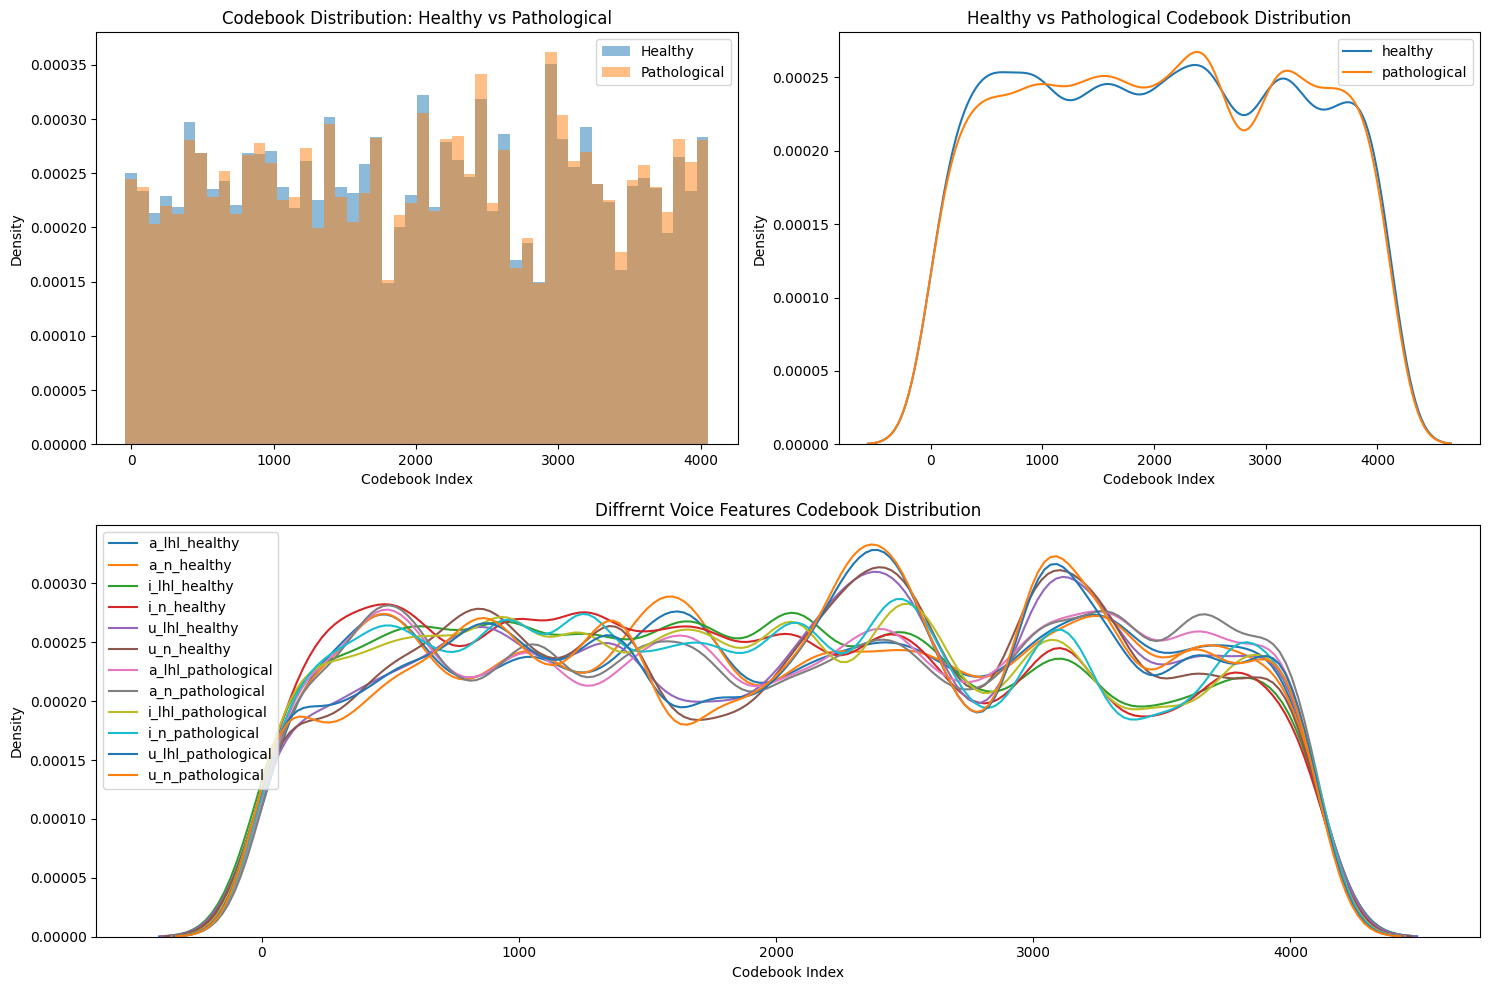

In [17]:
# 可视化类别之间的差异
def visualize_category_differences(results_df):
    """可视化不同类别之间的差异"""
    plt.figure(figsize=(15, 10))
    
    # 1. 健康vs病理学 - codebook使用频率对比
    plt.subplot(2, 2, 1)
    healthy_vectors = np.concatenate(results_df[results_df['health_status'] == 'healthy']['vector'].tolist())
    pathological_vectors = np.concatenate(results_df[results_df['health_status'] == 'pathological']['vector'].tolist())
    healthy_vectors.shape
    pathological_vectors.shape
    
    # 计算直方图数据但不绘制
    hist_healthy, bin_edges = np.histogram(healthy_vectors, bins=50, density=True)
    hist_patho, _ = np.histogram(pathological_vectors, bins=bin_edges, density=True)
    
    # 绘制直方图
    plt.bar(bin_edges[:-1], hist_healthy, width=(bin_edges[1]-bin_edges[0]), alpha=0.5, label='Healthy')
    plt.bar(bin_edges[:-1], hist_patho, width=(bin_edges[1]-bin_edges[0]), alpha=0.5, label='Pathological')
    plt.title('Codebook Distribution: Healthy vs Pathological')
    plt.xlabel('Codebook Index')
    plt.ylabel('Density')
    plt.legend()
    
    #2 不同音素的密度函数，health & pathological 8 section wach, 16 section in total
    plt.subplot(2, 2, 2)
    for health in results_df['health_status'].unique():
        health_vectors = np.concatenate(results_df[results_df['health_status'] == health]['vector'].tolist())
        # 限制数据点数量以提高性能
        if len(health_vectors) > 10000:
            health_vectors = np.random.choice(health_vectors, size=10000, replace=False)
        sns.kdeplot(health_vectors, label=health)
    plt.title('Healthy vs Pathological Codebook Distribution')
    plt.xlabel('Codebook Index')
    plt.ylabel('Density')
    plt.legend()
    
    
    # 3. 语音特征对比
    plt.subplot(2, 1, 2)
    voice_features = results_df['voice_feature'].unique()
    
    # 为每个语音特征创建一组数据
    for health in results_df['health_status'].unique():
        for voice in voice_features:
            voice_vectors = np.concatenate(results_df[(results_df['voice_feature'] == voice) & (results_df['health_status'] == health)]['vector'].tolist())
            sns.kdeplot(voice_vectors, label=f"{voice}_{health}")
    plt.title('Voice Feature Codebook Distribution')
    plt.xlabel('Codebook Index')
    plt.ylabel('Density')
    
    plt.title('Diffrernt Voice Features Codebook Distribution')
    plt.xlabel('Codebook Index')
    plt.ylabel('Density')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('category_differences.png', dpi=300)
    plt.show()

# 执行可视化
visualize_category_differences(results_df)

In [18]:
# 计算并保存 healthy 和 pathological 的 codebook 分布
def save_codebook_distribution(results_df, output_prefix="codebook_distribution"):
    """
    保存 healthy 和 pathological 的 codebook 分布数组
    """
    # 初始化 DataFrame
    healthy_index_count_pd = pd.DataFrame(columns=['codebook_index', 'density', 'count'])
    pathological_index_count_pd = pd.DataFrame(columns=['codebook_index', 'density', 'count'])

    # 获取 healthy 和 pathological 的向量
    healthy_vectors = np.concatenate(results_df[results_df['health_status'] == 'healthy']['vector'].tolist())
    pathological_vectors = np.concatenate(results_df[results_df['health_status'] == 'pathological']['vector'].tolist())

    # 计算 healthy 的分布
    healthy_unique, healthy_counts = np.unique(healthy_vectors, return_counts=True)
    healthy_density = healthy_counts / healthy_counts.sum()
    healthy_index_count_pd = pd.DataFrame({
        'codebook_index': healthy_unique,
        'density': healthy_density,
        'count': healthy_counts
    })

    # 计算 pathological 的分布
    pathological_unique, pathological_counts = np.unique(pathological_vectors, return_counts=True)
    pathological_density = pathological_counts / pathological_counts.sum()
    pathological_index_count_pd = pd.DataFrame({
        'codebook_index': pathological_unique,
        'density': pathological_density,
        'count': pathological_counts
    })

    # 保存到 CSV 文件
    healthy_index_count_pd.to_csv(f"{output_prefix}_healthy.csv", index=False)
    pathological_index_count_pd.to_csv(f"{output_prefix}_pathological.csv", index=False)

    print(f"已保存 healthy 和 pathological 的 codebook 分布到 {output_prefix}_healthy.csv 和 {output_prefix}_pathological.csv")

    return healthy_index_count_pd, pathological_index_count_pd

# 执行保存
healthy_index_count_pd, pathological_index_count_pd = save_codebook_distribution(results_df)

已保存 healthy 和 pathological 的 codebook 分布到 codebook_distribution_healthy.csv 和 codebook_distribution_pathological.csv


Code Index 范围: [0, 4095]
不同的 Code Index 数量: 3769
Codebook 大小: 4096


/tmp/ipykernel_155684/1990274419.py:33: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_155684/1990274419.py:33: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_155684/1990274419.py:33: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_155684/1990274419.py:33: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_155684/1990274419.py:35: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.savefig('code_index_distribution.png', dpi=300)
/tmp/ipykernel_155684/1990274419.py:35: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig('code_index_distribution.png', dpi=300)
/tmp/ipykernel_155684/1990274419.py:35: UserWarning: Glyph

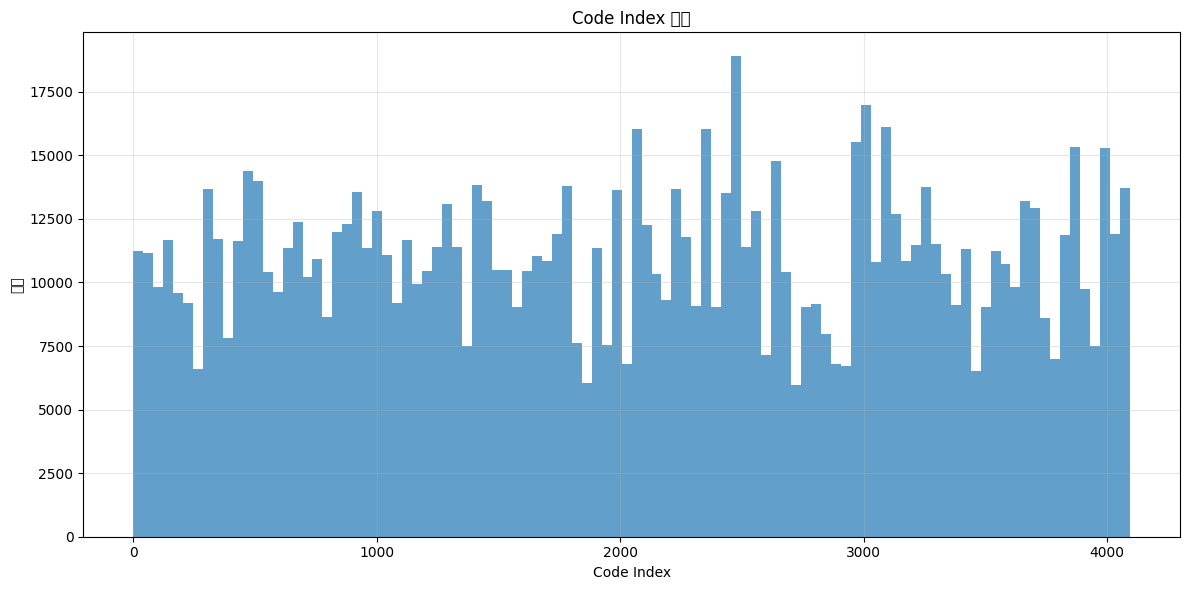

In [20]:
# 分析 discrete_code 的索引范围
def analyze_code_index_range(results_df):
    """分析 discrete_code 中所有索引值的范围"""
    
    # 合并所有向量
    all_vectors = np.concatenate(results_df['vector'].tolist())
    
    # 计算最小值、最大值和唯一值数量
    min_index = np.min(all_vectors)
    max_index = np.max(all_vectors)
    unique_indices = np.unique(all_vectors)
    
    print(f"Code Index 范围: [{min_index}, {max_index}]")
    print(f"不同的 Code Index 数量: {len(unique_indices)}")
    
    # 分析 codebook 大小（从模型中获取）
    try:
        # 如果 wavtokenizer 仍然可用
        codebook_size = wavtokenizer.feature_extractor.encodec.quantizer.bins
        print(f"Codebook 大小: {codebook_size}")
        
        if max_index >= codebook_size:
            print(f"警告: 存在超出 codebook 大小的索引值!")
    except:
        pass
    
    # 创建索引值分布直方图
    plt.figure(figsize=(12, 6))
    plt.hist(all_vectors, bins=min(100, len(unique_indices)), alpha=0.7)
    plt.title('Code Index 分布')
    plt.xlabel('Code Index')
    plt.ylabel('频率')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.savefig('code_index_distribution.png', dpi=300)
    plt.show()
    
    return min_index, max_index, unique_indices

# 调用函数
min_idx, max_idx, unique_idx = analyze_code_index_range(results_df)

In [26]:
def extract_codebook_values(wavtokenizer):
    """
    提取并返回 codebook 的值，不进行可视化
    
    Args:
        wavtokenizer: WavTokenizer 实例
        
    Returns:
        dict: 包含 codebook 值的字典
    """
    codebook_values = {}
    
    try:
        # 获取 codebook 信息
        encodec_quantizer = wavtokenizer.feature_extractor.encodec.quantizer
        vq_layers = encodec_quantizer.vq.layers
        
        print(f"量化器类型: {type(encodec_quantizer).__name__}")
        print(f"编码本数量: {len(vq_layers)}")
        print(f"每个编码本的大小: {encodec_quantizer.bins}")
        
        # 提取每个 codebook 的值
        for i, vq in enumerate(vq_layers):
            codebook = vq.codebook
            codebook_numpy = codebook.cpu().numpy()
            
            # 打印基本信息
            print(f"\nCodebook {i+1}:")
            print(f"  形状: {codebook.shape}")
            print(f"  值范围: [{codebook.min().item():.4f}, {codebook.max().item():.4f}]")
            print(f"  均值: {codebook.mean().item():.4f}")
            print(f"  标准差: {codebook.std().item():.4f}")
            
            # 存储 codebook 值
            codebook_values[f'codebook_{i+1}'] = codebook_numpy
            
            codebook_pd = pd.DataFrame(columns=['index', 'value'])
            codebook_pd['index'] = np.arange(codebook_numpy.shape[0])
            codebook_pd['value'] = codebook_numpy.tolist()
            codebook_pd['value'] = codebook_pd['value'].apply(lambda x: np.array(x).tolist())
            # 可选: 保存为 CSV 文件
            codebook_pd.to_csv(f'codebook_{i+1}_values.csv', index=False)
        
    except Exception as e:
        print(f"提取 codebook 值时出错: {str(e)}")
    
    return codebook_values

# 如果 wavtokenizer 可用，调用此函数
try:
    codebook_values = extract_codebook_values(wavtokenizer)
    
    # 可选：检查第一个 codebook 中的前 5 个向量
    if len(codebook_values) > 0:
        first_codebook = list(codebook_values.values())[0]
        print("\n第一个 codebook 的前 5 个向量:")
        for i in range(min(5, len(first_codebook))):
            print(f"向量 {i}: {first_codebook[i][:5]}... (仅显示前 5 个元素)")
    
except NameError:
    print("wavtokenizer 不可用，无法提取 codebook 值")

量化器类型: ResidualVectorQuantizer
编码本数量: 1
每个编码本的大小: 4096

Codebook 1:
  形状: torch.Size([4096, 512])
  值范围: [-1.3215, 1.2599]
  均值: -0.0014
  标准差: 0.2448

第一个 codebook 的前 5 个向量:
向量 0: [ 0.22442295  0.10449506 -0.21690181  0.0271819  -0.13112508]... (仅显示前 5 个元素)
向量 1: [-0.04355528 -0.10279181 -0.18979369  0.28373548 -0.01903524]... (仅显示前 5 个元素)
向量 2: [-0.15766549  0.05910397 -0.18685573 -0.27347818  0.19050452]... (仅显示前 5 个元素)
向量 3: [ 0.09166757  0.02545839 -0.38976792 -0.07938164 -0.05176005]... (仅显示前 5 个元素)
向量 4: [ 0.36390638 -0.08957551 -0.23902139  0.4392145  -0.3823391 ]... (仅显示前 5 个元素)
